# Image Segmentation

![segmentation](http://vladlen.info/wp-content/uploads/FSO-1.jpg)

# Get custom dataset from Github

In [0]:
!git clone https://github.com/lim-eren/CDnet2014.git

Cloning into 'CDnet2014'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [0]:
!ls */train/*

CDnet2014/train/x:
in000685.jpg  in000853.jpg  in001057.jpg  in001217.jpg	in001537.jpg
in000765.jpg  in000873.jpg  in001077.jpg  in001364.jpg	in001613.jpg
in000789.jpg  in000896.jpg  in001104.jpg  in001416.jpg	in001636.jpg
in000809.jpg  in000925.jpg  in001125.jpg  in001477.jpg	in001657.jpg
in000832.jpg  in001009.jpg  in001189.jpg  in001517.jpg	in001680.jpg

CDnet2014/train/y:
gt000685.png  gt000853.png  gt001057.png  gt001217.png	gt001537.png
gt000765.png  gt000873.png  gt001077.png  gt001364.png	gt001613.png
gt000789.png  gt000896.png  gt001104.png  gt001416.png	gt001636.png
gt000809.png  gt000925.png  gt001125.png  gt001477.png	gt001657.png
gt000832.png  gt001009.png  gt001189.png  gt001517.png	gt001680.png


# Use dataset uploaded to Google Drive

Download this .zip file and upload to your Google Drive https://goo.gl/ZXezxB

## Authenticate Colab to access Google drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Download our file to Jupyter

In [3]:
download = drive.CreateFile({'id':'18vvShz5rOCWNF6Eo5AQ3PgD_z5V7oUpG'}) # https://drive.google.com/file/d/<ID>/view?usp=sharing
download.GetContentFile('CDnet2014.zip')
!unzip CDnet2014.zip

Archive:  CDnet2014.zip
   creating: CDnet2014/
   creating: CDnet2014/train/
   creating: CDnet2014/test/
   creating: CDnet2014/train/y/
 extracting: CDnet2014/train/y/gt001680.png  
 extracting: CDnet2014/train/y/gt001657.png  
  inflating: CDnet2014/train/y/gt001636.png  
 extracting: CDnet2014/train/y/gt001613.png  
  inflating: CDnet2014/train/y/gt001537.png  
  inflating: CDnet2014/train/y/gt001517.png  
 extracting: CDnet2014/train/y/gt001477.png  
 extracting: CDnet2014/train/y/gt001416.png  
 extracting: CDnet2014/train/y/gt001364.png  
 extracting: CDnet2014/train/y/gt001217.png  
 extracting: CDnet2014/train/y/gt001189.png  
 extracting: CDnet2014/train/y/gt001125.png  
 extracting: CDnet2014/train/y/gt001104.png  
  inflating: CDnet2014/train/y/gt001077.png  
  inflating: CDnet2014/train/y/gt001057.png  
  inflating: CDnet2014/train/y/gt001009.png  
 extracting: CDnet2014/train/y/gt000925.png  
  inflating: CDnet2014/train/y/gt000896.png  
  inflating: CDnet2014/train/y/gt

##  Add this code snippet to obtain reproducible results across machines

In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


## Create a function to load data

In [0]:
import glob
from keras.preprocessing import image as kImage

def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        
        # Load ground-truth label and encode it to label 0 and 1
        x = kImage.load_img(Y_list[i], color_mode = "grayscale")
        x = kImage.img_to_array(x)
        x /= 255.0
        x = np.floor(x)
        Y.append(x)
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y

## Vanilla encoder-decoder network

In [0]:
import keras
from keras.models import Model
from keras.layers import Deconv2D, Input

def initModel():
    ### Encoder
    net_input = Input(shape=(240,320,3))
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)
    for layer in vgg16.layers[:17]:
      layer.trainable = False
    
    x = vgg16.layers[-2].output # 2nd layer from the last, block5_conv3
    
    ### Decoder
    x = Deconv2D(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(lr=5e-4), metrics=['accuracy'])
    return model

## Load data

In [0]:
# load data
dataset_path = os.path.join('CDnet2014', 'train')
X, Y = getData(dataset_path)

## Display dataset

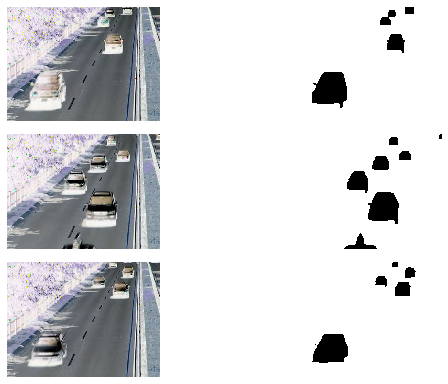

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(1,6,2):
  plt.tight_layout()
  plt.subplot(3,2,i)
  plt.imshow(X[i,:,:,:], interpolation='none')
  plt.xticks([])
  plt.yticks([])
  plt.subplot(3,2,i+1)
  plt.imshow(Y[i,:,:,0], interpolation='none')
  plt.xticks([])
  plt.yticks([])

## Train network

In [0]:
# init the model
model = initModel()

# print model arch
model.summary()

58892288/58889256 [==============================] - 4s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 320, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 160, 128)     147584    
_________________________________________________________________
block2_pool

In [0]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

model.fit(X, Y, batch_size=1, epochs=100, verbose=2, validation_split=0.2, callbacks=[reduce, early], shuffle=True)

Train on 20 samples, validate on 5 samples
Epoch 1/100
 - 4s - loss: 0.2404 - acc: 0.9035 - val_loss: 0.1077 - val_acc: 0.9077
Epoch 2/100
 - 1s - loss: 0.0959 - acc: 0.9424 - val_loss: 0.0796 - val_acc: 0.9683
Epoch 3/100
 - 1s - loss: 0.0714 - acc: 0.9723 - val_loss: 0.0509 - val_acc: 0.9774
Epoch 4/100
 - 1s - loss: 0.0520 - acc: 0.9775 - val_loss: 0.0525 - val_acc: 0.9767
Epoch 5/100
 - 1s - loss: 0.0473 - acc: 0.9813 - val_loss: 0.0509 - val_acc: 0.9795
Epoch 6/100
 - 1s - loss: 0.0447 - acc: 0.9814 - val_loss: 0.0427 - val_acc: 0.9820
Epoch 7/100
 - 1s - loss: 0.0360 - acc: 0.9850 - val_loss: 0.0416 - val_acc: 0.9830
Epoch 8/100
 - 1s - loss: 0.0312 - acc: 0.9869 - val_loss: 0.0415 - val_acc: 0.9834
Epoch 9/100
 - 1s - loss: 0.0308 - acc: 0.9874 - val_loss: 0.0547 - val_acc: 0.9791
Epoch 10/100
 - 1s - loss: 0.0279 - acc: 0.9882 - val_loss: 0.0407 - val_acc: 0.9839
Epoch 11/100
 - 1s - loss: 0.0235 - acc: 0.9901 - val_loss: 0.0474 - val_acc: 0.9834
Epoch 12/100
 - 1s - loss: 0.02

## Save model

In [0]:
model.save('my_model.h5')
model_file = drive.CreateFile({'title' : 'my_model.h5'})
model_file.SetContentFile('my_model.h5')
model_file.Upload()

# load model
# model = load_model('my_model.h5')

## Test our model

In [0]:
# load test data
dataset_path = os.path.join('CDnet2014', 'test')
X, Y = getData(dataset_path)
# predict
pred = model.predict(X, verbose=0, batch_size=1)
print(tf.Session().run(K.mean(K.equal(Y, K.round(pred)))))

0.98889714


## View our results

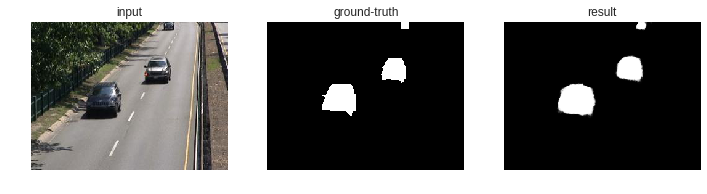

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = 2 # image index that you want to display

img = np.empty(3, dtype=object)
img[0] = X[idx]
img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])
img[2] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])
title = ['input', 'ground-truth', 'result']
for i in range(3):
  plt.subplot(1, 3, i+1)
  if i==0:
    plt.imshow(img[i].astype('uint8'))
  else:
    plt.imshow(img[i], cmap='gray')
  
  plt.axis('off')
  plt.title(title[i])
plt.show()

# Exercise for you

Design a image segmentation model for [semantic dataset](http://www.ntu.edu.sg/home/asjfcai/Benchmark_Website/Semantic%20dataset100.zip). 


![semantic](http://www.ntu.edu.sg/home/asjfcai/Benchmark_Website/semantic-example.png =600x)



Use the same above code and modify to this problem.